In [1]:
import numpy as np
# import cupy as np
import random
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass
from enum import Enum
import time

In [2]:
class Direction(Enum):
    LEFT = 0
    UP = 1
    RIGHT = 2
    DOWN = 3

In [3]:
import numpy as np

class Game2048Env:
    def __init__(self):
        self.grid_size = 4
        self.reset()
        
    def reset(self):
        self.board = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.spawn_tile()
        self.spawn_tile()
        self.score = 0
        return self.board.copy()
    
    def spawn_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if empty:
            x, y = empty[np.random.randint(len(empty))]
            self.board[x, y] = 2 if np.random.random() < 0.9 else 4
        
    def step(self, action: Direction):
        moved, reward = self.move(action.value)
        if moved:
            self.spawn_tile()
        else:
            # Stop if invalid move
            return self.board.copy(), reward, False, {}
        done = not self.can_move()
        self.score += reward
        return self.board.copy(), reward, done, {}
    
    def move(self, direction):
        board = np.copy(self.board)
        reward = 0
        moved = False

        # Rotate board so all moves are left-moves
        for _ in range(direction):
            board = np.rot90(board)
            
        for i in range(self.grid_size):
            tiles = board[i][board[i] != 0]  # Extract non-zero
            merged = []
            j = 0
            while j < len(tiles):
                if j + 1 < len(tiles) and tiles[j] == tiles[j + 1]:
                    merged_val = tiles[j] * 2
                    reward += merged_val
                    merged.append(merged_val)
                    j += 2  # Skip next
                    moved = True
                else:
                    merged.append(tiles[j])
                    j += 1
            # Pad with zeros to the right
            merged += [0] * (self.grid_size - len(merged))
            # Detect if move or merge happened
            if not np.array_equal(board[i], merged):
                moved = True
            board[i] = merged

        # Restore original orientation
        for _ in range((4 - direction) % 4):
            board = np.rot90(board)
            
        if moved:
            self.board = board

        return moved, reward

    
    def can_move(self):
        for direction in range(4):
            temp_board = self.board.copy()
            moved, _ = self.move(direction)
            self.board = temp_board  # Restore original
            if moved:
                return True
        return False



In [4]:
game = Game2048Env()
state = game.reset()
done = False

def print_board(board):
    for x in board:
        print("\t".join(f"{v:4}" for v in x))
    print("-" * 20)

print_board(state)

for _ in range(3):  # Play 10 random moves

    action = Direction(np.random.randint(4))  # Random action for demonstration
    state, reward, done, _ = game.step(action)

    print(f"Action: {action.name} | Score: {game.score}")
    print(f"Reward: {reward} | Done: {done}")
    
    print_board(state)
    
    

   0	   0	   0	   2
   2	   0	   0	   0
   0	   0	   0	   0
   0	   0	   0	   0
--------------------
Action: LEFT | Score: 0
Reward: 0 | Done: False
   2	   0	   0	   0
   2	   0	   0	   4
   0	   0	   0	   0
   0	   0	   0	   0
--------------------
Action: LEFT | Score: 0
Reward: 0 | Done: False
   2	   0	   0	   0
   2	   4	   0	   0
   0	   0	   0	   0
   0	   0	   2	   0
--------------------
Action: UP | Score: 4
Reward: 4 | Done: False
   4	   4	   2	   0
   0	   0	   0	   0
   0	   0	   0	   0
   0	   2	   0	   0
--------------------


In [5]:
class SimpleNeuralNetwork:
    """Simple feedforward netural network"""

    def __init__(self, input_size: int = 16, hidden_layers: List[int] = [8, 8], output_size: int = 4, empty: bool = False):
        if empty:
            return
        
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = []
        self.biases = []

        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            weight_matrix = np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2. / self.layers[i])
            bias_vector = np.zeros((self.layers[i+1],))
            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward pass through the network"""  
        a = x
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = self.tanh(z)

        # Output layer with linear activation
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        return z
    
    def mutate(self, mutation_rate: float = 0.1, mutation_strength: float = 0.5):
        """Mutate the network's weights and biases"""
        for i in range(len(self.weights)):
            if random.random() < mutation_rate:
                mutation = np.random.randn(*self.weights[i].shape) * mutation_strength
                self.weights[i] += mutation
                
            if random.random() < mutation_rate:
                mutation = np.random.randn(*self.biases[i].shape) * mutation_strength
                self.biases[i] += mutation

In [6]:
@dataclass
class GameResult:
    score: int
    max_tile: int
    moves: int

class Player:
    def __init__(self, network: SimpleNeuralNetwork):
        self.network = network

    def play(self, env: Game2048Env, max_steps: int = 100) -> int:
        state = env.reset()
        total_reward = 0
        done = False
        steps = 0

        while not done and steps < max_steps:
            action = self.next_move(state)

            state, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1

        return GameResult(score=total_reward, max_tile=np.max(state), moves=steps)
    
    def next_move(self, state: np.ndarray) -> Direction:
        flat_state = state.flatten() / 2048.0  # Normalize input
        q_values = self.network.forward(flat_state)
        action = Direction(np.argmax(q_values))  # Choose action with highest Q-value
        return action

In [7]:
class EvolutionaryOptimizer:
    def __init__(
            self, 
            population_size: int = 50, 
            elite_size: int = 10,
            mutation_rate: float = 0.1, 
            mutation_strength: float = 0.5
        ):
        self.population_size = population_size
        self.elite_size = elite_size
        self.mutation_rate = mutation_rate
        self.mutation_strength = mutation_strength
        self.population = [SimpleNeuralNetwork(hidden_layers=[256, 256, 256]) for _ in range(population_size)]

    def evaluate(self, env: Game2048Env, games_per_player: int = 5, max_steps: int = 100) -> List[Tuple[SimpleNeuralNetwork, float]]:
        results = []
        for network in self.population:
            player = Player(network)
            total_score = 0
            for _ in range(games_per_player):
                game_result = player.play(env, max_steps=max_steps)
                total_score += game_result.score
            avg_score = total_score / games_per_player
            results.append((network, avg_score))
        return results

    def select_and_breed(self, evaluated: List[Tuple[SimpleNeuralNetwork, float]]) -> None:
        # Sort by score descending
        evaluated.sort(key=lambda x: x[1], reverse=True)
        elite = evaluated[:self.elite_size] 

        new_population = []
        new_population.extend([net for net, _ in elite])
        while len(new_population) < self.population_size:
            network = random.choice(elite)[0]
            new_population.append(network)  # Keep the best
            # hidden_layers = np.random.randint(0, 128, size=np.random.randint(1, 8))
            child = SimpleNeuralNetwork()
            child.weights = [np.copy(w) for w in network.weights]
            child.biases = [np.copy(b) for b in network.biases]
            child.mutate(self.mutation_rate, self.mutation_strength)
            new_population.append(child)

        self.population = new_population[:self.population_size]

    def run_generation(self, env: Game2048Env, games_per_player: int = 5, max_steps: int = 1000) -> float:
        evaluated = self.evaluate(env, games_per_player, max_steps=max_steps)
        avg_score = sum(score for _, score in evaluated) / len(evaluated)
        self.select_and_breed(evaluated)
        return avg_score

⏳ 1:13:14.673436 | Generation 1/60 - Average Score: 26.88
⏳ 1:12:52.178335 | Generation 2/60 - Average Score: 28.116000000000007
⏳ 1:11:58.864367 | Generation 3/60 - Average Score: 38.09600000000001
⏳ 1:10:53.512066 | Generation 4/60 - Average Score: 40.556000000000004
⏳ 1:09:47.931015 | Generation 5/60 - Average Score: 44.804000000000016
⏳ 1:08:31.127821 | Generation 6/60 - Average Score: 44.243999999999986
⏳ 1:07:06.103704 | Generation 7/60 - Average Score: 46.83199999999999
⏳ 1:05:42.172185 | Generation 8/60 - Average Score: 47.916
⏳ 1:04:24.226478 | Generation 9/60 - Average Score: 47.20399999999999
⏳ 1:03:02.207000 | Generation 10/60 - Average Score: 53.224000000000025
⏳ 1:01:47.168579 | Generation 11/60 - Average Score: 52.13599999999999
⏳ 1:00:30.900487 | Generation 12/60 - Average Score: 54.18400000000001
⏳ 0:59:20.481606 | Generation 13/60 - Average Score: 59.62
⏳ 0:58:15.071732 | Generation 14/60 - Average Score: 62.85599999999999
⏳ 0:57:04.806919 | Generation 15/60 - Average

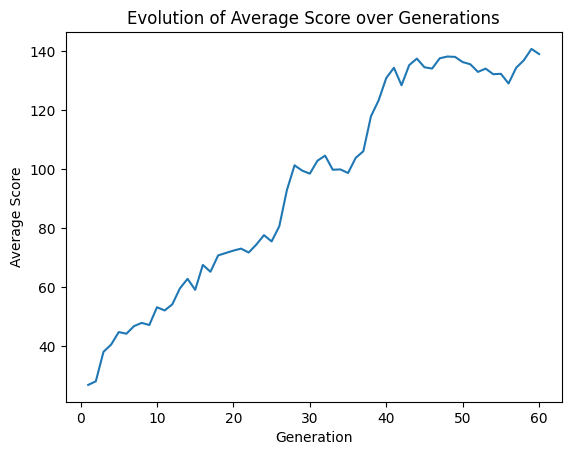

In [8]:
best_network = None
best_score = 0

from datetime import timedelta

def main():
    env = Game2048Env()
    optimizer = EvolutionaryOptimizer(population_size=100, elite_size=50, mutation_rate=0.1, mutation_strength=0.3)
    generations = 60
    games_per_player = 10
    max_steps = 1000

    avg_scores = []

    loop_start_time = time.time()

    for gen in range(generations):
        #start_time = time.time()
        avg_score = optimizer.run_generation(env, games_per_player, max_steps)
        avg_scores.append(avg_score)
        elapsed_time = time.time() - loop_start_time
        average_time_per_iteration = elapsed_time / (gen + 1)
        duration = str(timedelta(seconds=(average_time_per_iteration * (generations - gen + 1))))
        print(f"⏳ {duration} | Generation {gen+1}/{generations} - Average Score: {avg_score}")

    global best_network, best_score
    evaluated = optimizer.evaluate(env, games_per_player)
    best_network, best_score = max(evaluated, key=lambda x: x[1])

    # Plot average scores over generations
    plt.plot(range(1, generations + 1), avg_scores)
    plt.xlabel('Generation')
    plt.ylabel('Average Score')
    plt.title('Evolution of Average Score over Generations')
    plt.show()

if __name__ == "__main__":
    main()

In [9]:
# Playing with the best network
if best_network:
    best_tile = 0
    best_score = 0
    for _ in range(100):
        env = Game2048Env()
        player = Player(best_network)
        result = player.play(env, max_steps=1000)
        best_tile = result.max_tile if best_tile < result.max_tile else best_tile
        best_score = result.score if best_score < result.score else best_score
        print(f"Played a game - Score: {result.score}, Max Tile: {result.max_tile}, Moves: {result.moves}")
    print(f"Best tile: {best_tile}, Best score: {best_score}")

Played a game - Score: 168, Max Tile: 32, Moves: 1000
Played a game - Score: 156, Max Tile: 16, Moves: 1000
Played a game - Score: 140, Max Tile: 16, Moves: 1000
Played a game - Score: 52, Max Tile: 8, Moves: 1000
Played a game - Score: 232, Max Tile: 32, Moves: 1000
Played a game - Score: 144, Max Tile: 16, Moves: 1000
Played a game - Score: 180, Max Tile: 32, Moves: 1000
Played a game - Score: 184, Max Tile: 16, Moves: 1000
Played a game - Score: 108, Max Tile: 16, Moves: 1000
Played a game - Score: 104, Max Tile: 16, Moves: 1000
Played a game - Score: 272, Max Tile: 32, Moves: 1000
Played a game - Score: 136, Max Tile: 16, Moves: 1000
Played a game - Score: 132, Max Tile: 16, Moves: 1000
Played a game - Score: 144, Max Tile: 16, Moves: 1000
Played a game - Score: 52, Max Tile: 8, Moves: 1000
Played a game - Score: 144, Max Tile: 16, Moves: 1000
Played a game - Score: 72, Max Tile: 8, Moves: 1000
Played a game - Score: 196, Max Tile: 32, Moves: 1000
Played a game - Score: 56, Max Til

In [10]:
import time

if best_network:
    env = Game2048Env()
    player = Player(best_network)

    while True:
        board = env.board
        print_board(board)
        action = player.next_move(board)
        prev_state = state.copy()
        state, reward, done, _ = env.step(action)
        print(f"Action: {action.name}, Best: {np.max(state)}")
        if (prev_state == state).all():
            print("nop")
            print_board(prev_state)
            print_board(state)
            break
        if done:
            print("Game Over")
            print_board(state)
            break

        #time.sleep(.2)  # Pause for a second to visualize

    

   0	   0	   0	   0
   0	   0	   2	   0
   0	   0	   0	   2
   0	   0	   0	   0
--------------------
Action: LEFT, Best: 2
   0	   0	   0	   0
   2	   0	   0	   0
   2	   0	   2	   0
   0	   0	   0	   0
--------------------
Action: UP, Best: 4
   4	   0	   2	   0
   0	   0	   0	   0
   4	   0	   0	   0
   0	   0	   0	   0
--------------------
Action: RIGHT, Best: 4
   0	   0	   4	   2
   0	   0	   0	   0
   0	   0	   0	   4
   0	   2	   0	   0
--------------------
Action: LEFT, Best: 4
   4	   2	   2	   0
   0	   0	   0	   0
   4	   0	   0	   0
   2	   0	   0	   0
--------------------
Action: RIGHT, Best: 4
   0	   0	   4	   4
   0	   0	   0	   0
   0	   0	   0	   4
   0	   0	   2	   2
--------------------
Action: LEFT, Best: 8
   8	   0	   0	   0
   0	   0	   0	   0
   4	   0	   0	   0
   4	   0	   2	   0
--------------------
Action: RIGHT, Best: 8
   0	   0	   0	   8
   0	   0	   0	   0
   0	   2	   0	   4
   0	   0	   4	   2
--------------------
Action: LEFT, Best: 8
   8	   0	   0	

In [11]:
import pickle

with open(f"bestnetwork-{time.time()}.pkl", "wb") as f:
    pickle.dump(best_network, f)